In [20]:
#list all json files
#read json files
#remove points in buffer region
#count points

In [1]:
import json
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
json_ffn     = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/hailpixel_20181126_final_hq_complete.json'
ref_ffn      = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/index.csv'

In [3]:
#read reference file
df = pd.read_csv(ref_ffn, header=0)
ref_dict = df.to_dict(orient='list')

In [20]:
hail_count   = 0
hail_skipped = 0
buffer_px    = 50
hail_x       = []
hail_y       = []
hail_major   = []
hail_ratio   = []
hq_x         = []
hq_y         = []
hq_id        = []
tile_count   = []


#open json index file
with open(json_ffn) as json_fh:  
    data = json.load(json_fh)

#load keys from file
json_keys = list(data.keys())[0:]


for key_idx in range(0, len(json_keys)):
    tile_count_temp = 0
    #extract image json
    image_json = data[json_keys[key_idx]]

    #loop through regions in annotation file
    region_json = image_json['regions']
    
    #find reference coordinates for subset
    subset_idx = int(json_keys[key_idx][0:4])
    ref_idx    = ref_dict['idx'].index(int(subset_idx))
    x0 = ref_dict['x0'][ref_idx]
    y0 = ref_dict['y0'][ref_idx]
    
    #add subset coordinates
    hq_x.append(x0 + 250)
    hq_y.append(y0 + 250)
    hq_id.append(subset_idx)
    
    for region_idx, region in enumerate(region_json):
        #for regions of type point
        if region['shape_attributes']['name'] == 'point':
            cx = region['shape_attributes']['cx']
            cy = region['shape_attributes']['cy']
            #skip if in padding region
            if cx < 50 or cx > 550 or cy < 50 or cy > 550:
                continue
            #add to lists
            hail_count += 1
            tile_count_temp += 1
            hail_x.append(x0+cx)
            hail_y.append(y0+cy)
    tile_count.append(tile_count_temp)

    
# print('final hail count:', hail_count)
# print('final hail skipped:', hail_skipped)

# print('final image:', hail_count)



In [24]:
#calculate concentration on tiles
tile_concentration = np.array(tile_count)/(1.35*1.35)

print(np.min(tile_concentration), np.max(tile_concentration), np.mean(tile_concentration))

14.266117969821671 91.08367626886144 46.6509062253743


In [5]:
hail_x_m = np.array(hail_x) * 0.0027
hail_y_m = np.array(hail_y) * 0.0027

hq_x_m = np.array(hq_x) * 0.0027
hq_y_m = np.array(hq_y) * 0.0027


In [7]:
print(500*0.0027) #width of subsets in m

1.35


1.0973936899862824 85.04801097393688


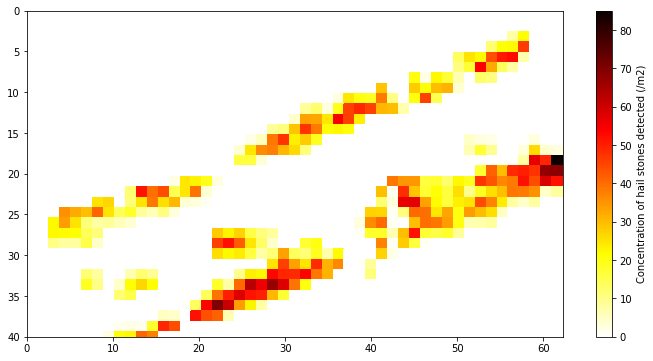

In [14]:
xbins = np.arange(0, 62.5, 1.27) 
ybins = np.arange(0, 41, 1.27)

#compute 2d hist matrix
counts, _, _ = np.histogram2d(hail_x_m, hail_y_m, bins=(xbins, ybins))
counts = counts/(1.35*1.35)
#plot 2d hist matrix 
fig = plt.figure(facecolor='white',figsize=[12,6])
ax = plt.subplot(1, 1, 1)
im = ax.pcolormesh(xbins, ybins, counts.T, cmap='hot_r') #pcolormesh expect Y,X axes order
plt.ylim(40, 0)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Concentration of hail stones detected (/m2)')

print(np.min(counts[counts>1]), np.max(counts))

In [10]:
#create interactive heatmap with maerks showing subset if of high quality subsets

from plotly.offline import plot
import plotly.graph_objs as go


trace1 = go.Heatmap(z=counts.T, x=xbins, y=ybins, hoverinfo='none', colorscale='hot_r')
trace2 = go.Scatter(x = hq_x_m, y = hq_y_m, text = hq_id, hoverinfo='text', mode = 'markers', marker=dict(color='black'))
layout= go.Layout(hovermode= 'closest', yaxis = dict(autorange = "reversed"))
    
fig= go.Figure(data=[trace1, trace2], layout=layout)
plot(fig, filename='heatmap.html')

'file:///home/548/jss548/dev/SevereWeather/hailpixel/postprocessing/heatmap.html'